<a href="https://colab.research.google.com/github/MuhammadRhakan/final_project/blob/secondary/Experimentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install leidenalg igraph networkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 101.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 123.7 MB/s eta 0:00:00


In [2]:
import nltk
import kagglehub
import sys
import h5py
import random
import leidenalg
import json

import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
import networkit as nk

from kagglehub.datasets import KaggleDatasetAdapter
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import *
from scipy.sparse import csr_matrix, vstack
from collections import Counter

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [64]:
course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")

/tmp/ipython-input-64-193580186.py:1: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  course = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "hossaingh/udemy-courses", "Course_info.csv")


In [66]:
#fill missing last update date
def fill_empty_date(data, features):
  data = data.copy()
  for col in features:
    data[col] = pd.to_datetime(data[col], utc=True)

  data[features[1]] = data[features[1]].fillna(data[features[0]])

  return data


#get latest 5 years data
def get_latest_five_years(data, features):
  data = data.copy()
  latest_year = data[features[0]].max().year
  last_five_year = latest_year - 5

  data = data[(data[features[0]].dt.year > last_five_year) & (data[features[1]].dt.year > last_five_year)]

  return data


#basic cleaning
def initial_cleaning_phase(course):
  course = course.copy()
  null_values = course[(course['num_lectures'] == 0) |
                (course['content_length_min'] == 0) |
                ((course['avg_rating'] == 0) & (course['num_reviews'] > 0))].index
  clean_data = course.drop(index=null_values).dropna()

  return clean_data

In [67]:
course = course[course['language'].isin({'English'})]
course = fill_empty_date(course, ['published_time', 'last_update_date'])
course = get_latest_five_years(course, ['published_time', 'last_update_date'])
course = initial_cleaning_phase(course)
print(course.shape)

(89225, 20)


In [69]:
#separate numeric and non-numeric attributes
def get_numerical_attributes(data, exclude):
  numerical = []
  print(f"Numerical Attributes:")
  for num in data.select_dtypes(include = 'number').drop(columns='id').columns:
    if num != exclude:
      numerical.append(num)
      print(f"• {num}")

  return numerical


#handle outliers using clips
def outlier_clipping(data, features, par, skip):
  data = data.copy()

  clip = data.copy()
  for col in features:
    upper = data[col].quantile(par)
    lower = data[col].quantile(1-par)
    clip[col] = clip[col].clip(upper=upper, lower=lower)

  transformed = clip.copy()
  transformed[features] = np.log1p(transformed[features])

  return clip, transformed



#label categorical values
def features_labeling(data, features):
  label = data.copy()
  label['rounded_rating'] = (label[features[1]].copy()).astype(int)
  label['rating_label'] = label['rounded_rating'].apply(lambda x: 'bad' if x < 3 else ('mid' if x == 3 else 'good'))

  return label


#check distributions
def box_visualization(data, features):
  sns.boxplot(data[features])
  plt.xticks(rotation=45)
  plt.tight_layout()
  plt.show()

In [70]:
numerical = get_numerical_attributes(course, exclude='avg_rating')
course_completed = features_labeling(course, features=['is_paid','avg_rating'])

course_clip, course_clip_scaled = outlier_clipping(course_completed,
                                                   features=numerical,
                                                   par=0.9,
                                                   skip='price')

Numerical Attributes:
• price
• num_subscribers
• num_reviews
• num_comments
• num_lectures
• content_length_min


In [71]:
def trace_item_index(data, feature):
  new_order = data[feature].reset_index()
  new_order = new_order.rename(columns={'index': 'Raw index', 'id': 'Item ID'})

  return new_order

indices = trace_item_index(course_clip, feature='id')
indices

,Raw index,Item ID
0,180,17704.0
1,509,28695.0
2,1097,51334.0
3,1113,51648.0
4,1129,51942.0
...,...,...
89220,209724,4912840.0
89221,209725,4913148.0
89222,209727,4913922.0
89223,209729,4913954.0


In [17]:
def semantic_preprocessing(data, features, id):
  stop_words = set(stopwords.words('english'))
  lemmatizer = WordNetLemmatizer()

  combined_text =[]
  for col in features:
    semantic = data[col].str.lower()
    semantic = semantic.apply(lambda text: ' '.join([lemmatizer.lemmatize(word) for word in word_tokenize(text) if word not in stop_words]))
    combined_text.append(semantic)

  semantic = pd.concat(combined_text, axis=1).apply(lambda x: ' '.join(x), axis=1)

  vectorizer = TfidfVectorizer(max_features=1000, min_df=3, max_df=0.9, ngram_range=(1, 3), dtype=np.float32)
  tfidf_matrix = vectorizer.fit_transform(semantic)
  tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
  tfidf_df[id] = data[id].values
  tfidf_df = tfidf_df.set_index(id)

  return tfidf_matrix.toarray(), tfidf_df

In [74]:
def numerical_preprocessing(data, features, id):
  correlation_score = data[features].corr()
  upper = correlation_score.where(np.triu(np.ones(correlation_score.shape), k=1).astype(bool))
  redundant = [col for col in upper.columns if any(upper[col] > 0.85)]

  numeric = data[features].drop(columns=redundant)

  scaler = MinMaxScaler()
  normalized_matrix = scaler.fit_transform(numeric)
  normalized_df = pd.DataFrame(data=normalized_matrix, columns=numeric.columns)
  normalized_df[id] = data[id].values
  normalized_df = normalized_df.set_index(id)

  return normalized_matrix, normalized_df

In [61]:
def nominal_preprocessing(data, features, id):
  nominal = data[features].copy().reset_index(drop=True)

  for col in nominal.columns:
    if nominal[col].dtype == 'datetime64[ns, UTC]':
      nominal[col] = nominal[col].dt.year.astype(str)

  nominal = nominal.loc[:, nominal.nunique() > 1]

  multiattribute_df = pd.get_dummies(nominal)
  multiattribute_matrix = multiattribute_df.values
  multiattribute_df[id] = data[id].values
  multiattribute_df = multiattribute_df.set_index(id)

  return multiattribute_matrix, multiattribute_df

In [75]:
semantic_matrix, semantic_df = semantic_preprocessing(course_clip, features=['title', 'headline', 'topic'], id='id')
numeric_matrix, numeric_df = numerical_preprocessing(course_clip_scaled, numerical, id='id')
nominal_matrix, nominal_df = nominal_preprocessing(course_clip, features=['is_paid', 'category', 'subcategory', 'rating_label', 'published_time', 'last_update_date'], id='id')

In [78]:
def feature_combination(*data, form):
  initial = data[0]
  for i in data[1:]:
    if form =='df':
      initial = pd.concat([initial, i], axis=1)
    elif form == 'matrix':
      initial = np.concatenate((initial, i), axis=1)
    else:
      raise ValueError("form must be 'df' or 'matrix'")

  combined = initial

  return combined

In [79]:
multiattribute_matrix = feature_combination(semantic_matrix, numeric_matrix, nominal_matrix, form='matrix')
multiattribute_df = feature_combination(semantic_df, numeric_df, nominal_df, form='df')

In [80]:
print(f'Matrix shape: {multiattribute_matrix.shape}')
print(f'Matrix size: {sys.getsizeof(multiattribute_matrix)/1000000} MB')

Matrix shape: (89225, 1162)
Matrix size: 829.435728 MB


In [118]:
index_to_node = multiattribute_df.index.to_list()

In [120]:
def single_multiattributes_pipeline_batched(data, nominal_group_sizes, block_size=1000, output_path='multiattribute_similarity.h5'):
  N = len(data)

  semantic_block = data[:, slice(0, 1000)] #1000 vectorized semantic feature
  numeric_block = data[:, slice(1000, 1005)] # 5 original numerics
  nominal_block = data[:, slice(1005, 1162)] # 157 encoded categorical

  nominal_group_sizes = nominal_group_sizes

  with h5py.File(output_path, 'w') as f:
    sim_matrix = f.create_dataset('similarity', shape=(N, N), dtype='float32')

    for start in range(0, N, block_size):
      end = min(start + block_size, N)
      print(f"Processing block {start}:{end}")

      # 1. Semantic: block vs all
      semantic_block_part = semantic_block[start:end]
      semantic_sim = cosine_similarity(semantic_block_part, semantic_block)

      # 2. Numeric: block vs all
      numeric_block_part = numeric_block[start:end]
      numeric_dist = euclidean_distances(numeric_block_part, numeric_block)
      numeric_sim = 1 / (1 + numeric_dist)

      # 3. Nominal: multiple groups
      dice_sims = []
      start_col = 0
      for cols in nominal_group_sizes:
        end_col = start_col + cols
        nom_all = nominal_block[:, start_col:end_col]
        nom_part = nom_all[start:end, :]

        ni = nom_part.sum(axis=1)
        nj = nom_all.sum(axis=1)

        nij = nom_part @ nom_all.T

        denom = ni[:, None] + nj[None, :]
        denom[denom == 0] = 1e-12

        dice = (2 * nij) / denom
        dice_sims.append(dice)
        start_col = end_col

      # Combine similarities
      multiattribute_similarity = (semantic_sim + numeric_sim + sum(dice_sims)) / 8

      # Zero out lower triangle for symmetry (optional)
      for i in range(end - start):
        abs_row = start + i
        multiattribute_similarity[i, :abs_row] = 0.0

      # Write to HDF5
      sim_matrix[start:end, :] = multiattribute_similarity

  print(f"Done! Similarity matrix saved in: {output_path}")

In [121]:
single_multiattributes_pipeline_batched(multiattribute_matrix,
                                        nominal_group_sizes=[1,13,130,3,5,5]) #1 paid status, 13 categories, 130 subcategories, 3 ratings, 5 publised years, 5 updated years

Processing block 0:1000
Processing block 1000:2000
Processing block 2000:3000
Processing block 3000:4000
Processing block 4000:5000
Processing block 5000:6000
Processing block 6000:7000
Processing block 7000:8000
Processing block 8000:9000
Processing block 9000:10000
Processing block 10000:11000
Processing block 11000:12000
Processing block 12000:13000
Processing block 13000:14000
Processing block 14000:15000
Processing block 15000:16000
Processing block 16000:17000
Processing block 17000:18000
Processing block 18000:19000
Processing block 19000:20000
Processing block 20000:21000
Processing block 21000:22000
Processing block 22000:23000
Processing block 23000:24000
Processing block 24000:25000
Processing block 25000:26000
Processing block 26000:27000
Processing block 27000:28000
Processing block 28000:29000
Processing block 29000:30000
Processing block 30000:31000
Processing block 31000:32000
Processing block 32000:33000
Processing block 33000:34000
Processing block 34000:35000
Process

In [ ]:
def load_similarity_matrix(file_path):
  with h5py.File(file_path, 'r') as f:
    sim_matrix = f['similarity'][:]

In [122]:
def similarity_samples(file_path, top_k=30):
  with h5py.File(file_path, 'r') as f:
    similarity_matrix = f['similarity'][:]

  num_items = similarity_matrix.shape[0]

  top_k_neighbors = {}
  for i in range(num_items):
    sims = similarity_matrix[i]
    indices = np.argsort(sims)[::-1]
    indices = indices[indices != i]

    ego_id = index_to_node[i]
    neighbors = []
    for j in indices[:top_k]:
        neighbor_id = index_to_node[j]
        neighbors.append([int(neighbor_id), float(sims[j])])

    top_k_neighbors[str(ego_id)] = neighbors

  with open("top_k_neighbors.json", "w") as f:
    json.dump(top_k_neighbors, f)

  return top_k_neighbors

similarity_samples('multiattribute_similarity.h5')

{'17704.0': [[4032878, 0.8610454797744751],
  [3491982, 0.8584471344947815],
  [3916400, 0.8349414467811584],
  [4343954, 0.8321463465690613],
  [3827430, 0.8191822171211243],
  [3862664, 0.8186269402503967],
  [3880740, 0.8071356415748596],
  [4010200, 0.8029823303222656],
  [4822326, 0.7497425675392151],
  [4844018, 0.7489837408065796],
  [4233312, 0.7449079155921936],
  [4047194, 0.7444959282875061],
  [4361052, 0.7436718344688416],
  [4861672, 0.7436153888702393],
  [3738832, 0.7434051036834717],
  [4155234, 0.7429682016372681],
  [4100106, 0.7425269484519958],
  [4676456, 0.7421537637710571],
  [4042828, 0.7407060861587524],
  [3766510, 0.7382864952087402],
  [3740930, 0.7381637096405029],
  [4562046, 0.7376441359519958],
  [4397852, 0.737291693687439],
  [4427084, 0.7370778322219849],
  [4431532, 0.7369509935379028],
  [3911942, 0.7365259528160095],
  [4210344, 0.7364866137504578],
  [4003886, 0.7360932230949402],
  [4438694, 0.7360613346099854],
  [3905996, 0.7359785437583923]],

In [ ]:
def incremental_network_graph_model_hdf5(h5_file, threshold):
  G = nx.Graph()

  with h5py.File(h5_file, 'r') as f:
    sim_matrix = f['similarity']
    N = sim_matrix.shape[0]

    G.add_nodes_from(index_to_node)

    for i in range(N):
      row = sim_matrix[i, i+1:]  # read only needed slice
      indices = (row >= threshold).nonzero()[0]
      for idx in indices:
        j = i + 1 + idx  # correct absolute column index
        node_i = index_to_node[i]
        node_j = index_to_node[j]
        G.add_edge(node_i, node_j, weight=row[idx])

  print(f"Number of nodes: {G.number_of_nodes()}")
  print(f"Number of edges: {G.number_of_edges()}")

  return G

In [ ]:
G = incremental_network_graph_model_hdf5('multiattribute_similarity.h5', threshold=0.75)

Number of nodes: 52904
Number of edges: 3504471


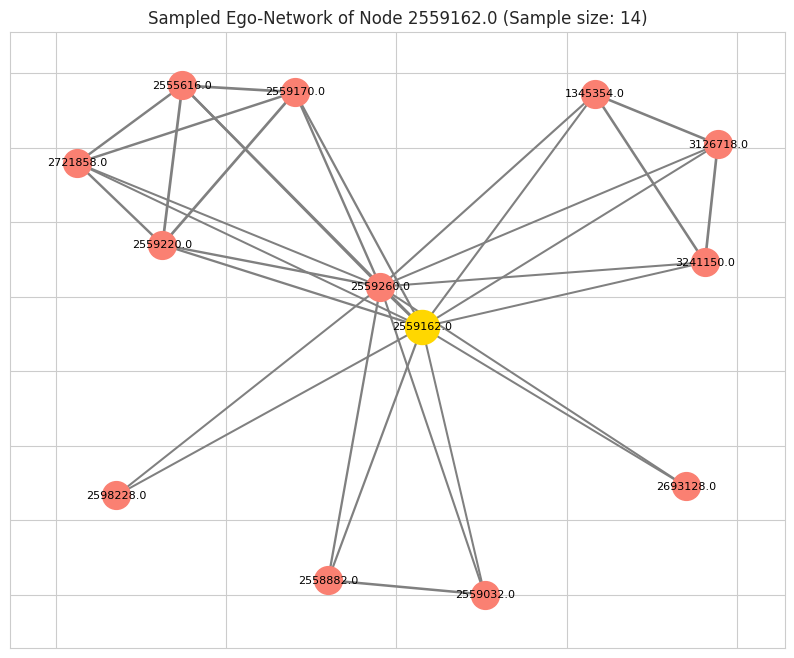

In [ ]:
def network_graph_sampling(G, central_node, sample_size=50):
  if central_node is None:
    degrees = dict(G.degree())
    central_node = max(degrees, key=degrees.get)
    print(f"Central node: {central_node}, degree: {degrees[central_node]}")

  ego = nx.ego_graph(G, central_node, radius=1)
  nodes_in_ego = list(ego.nodes())

  if sample_size >= len(nodes_in_ego):
    sampled_neighbors  = nodes_in_ego
  else:
    sampled_neighbors  = random.sample(nodes_in_ego, sample_size-1)

  sampled_nodes = [central_node] + sampled_neighbors
  sampled_ego = ego.subgraph(sampled_nodes)

  edge_weights = [ego[u][v].get('weight', 1.0) for u, v in sampled_ego.edges()]
  max_weight = max(edge_weights) if edge_weights else 1.0
  widths = [2 * (w / max_weight) for w in edge_weights]  # scale factor for visibility

  plt.figure(figsize=(10, 8))
  pos = nx.spring_layout(sampled_ego, seed=42)
  other_nodes = [n for n in sampled_ego.nodes() if n != central_node]
  nx.draw_networkx_nodes(sampled_ego, pos,
                          nodelist=other_nodes,
                          node_color='salmon',
                          node_size=400,
                          label='Neighbors')
  nx.draw_networkx_nodes(sampled_ego, pos,
                          nodelist=[central_node],
                          node_color='gold',
                          node_size=600,
                          label='Central Node')
  nx.draw_networkx_edges(sampled_ego, pos,
                          width=widths,
                          edge_color='gray')
  nx.draw_networkx_labels(sampled_ego, pos, font_size=8)
  plt.title(f"Sampled Ego-Network of Node {central_node} (Sample size: {len(sampled_nodes)})")
  plt.show()

network_graph_sampling(G, central_node=random.choice(index_to_node), sample_size=30)

In [ ]:
def leiden_community_detection(G, partition_type):
  G_igraph = ig.Graph.from_networkx(G)
  partition = leidenalg.find_partition(G_igraph, partition_type)
  print(f"Number of communities: {len(partition)}")

  modularity_scores = partition.modularity
  print(f"Modularity Score: {modularity_scores:.3f}")

  community_size = Counter(partition.membership)
  top_communities = [com for com, size in community_size.items() if size > 10]

leiden_community_detection(G, leidenalg.ModularityVertexPartition)

Number of communities: 64
Modularity Score: 0.919


In [ ]:
def centrality_metrics_networkit(G_nx):
    # Convert to NetworKit graph
    G_nk = nk.nxadapter.nx2nk(G_nx)

    deg = np.array(nk.centrality.DegreeCentrality(G_nk).run().scores())
    clo = np.array(nk.centrality.Closeness(G_nk, True, nk.centrality.ClosenessVariant.GENERALIZED).run().scores())
    bet = np.array(nk.centrality.Betweenness(G_nk, normalized=True).run().scores())
    avg = [(d + c + b) / 3 for d, c, b in zip(deg, clo, bet)]

    def minmax_normalization(x):
        return (x - x.min()) / (x.max() - x.min()) if x.max() > x.min() else np.zeros_like(x)

    deg_norm = deg / (G_nk.numberOfNodes() - 1)
    clo_norm = minmax_normalization(clo)
    bet_norm = bet
    avg_norm = (deg_norm + clo_norm + bet_norm) / 3

    centrality_df = pd.DataFrame({
        "item": list(G_nx.nodes()),
        "degree": deg,
        "degree_normalized": deg_norm,
        "closeness": clo,
        "closeness_normalized": clo_norm,
        "betweenness": bet,
        "betweenness_normalized": bet_norm,
        "average_centrality": avg,
        "average_centrality_normalized": avg_norm
    })

    centrality_df.to_csv("centrality_full.csv", index=False)

centrality_metrics_networkit(G)

In [ ]:
def recommendation_phase(data, id, ego, top_n=10, normalized=True, verbose=True):
  with open("top_k_neighbors.json") as f:
    top_k_neighbors = json.load(f)

  centrality_df = pd.read_csv("centrality_full.csv", dtype={'item': int})
  centrality_df.set_index("item", inplace=True)
  candidates = top_k_neighbors.get(str(ego), [])

  suffix = "_normalized" if normalized else ""
  col_AC = f"average_centrality{suffix}"
  col_DC = f"degree{suffix}"
  col_CC = f"closeness{suffix}"
  col_BC = f"betweenness{suffix}"

  CEF_records = []
  for neighbor, _ in candidates:
    neighbor = int(neighbor)
    try:
      distance = nx.shortest_path_length(G, source=int(ego), target=neighbor)
      if distance > 0:
        ac = centrality_df.at[neighbor, col_AC]
        cef = ac / distance
        CEF_records.append({
          "id": neighbor,
          "CEF": cef,
          "links": distance,
          "DC": centrality_df.at[neighbor, col_DC],
          "BC": centrality_df.at[neighbor, col_BC],
          "CC": centrality_df.at[neighbor, col_CC]
        })
    except (nx.NetworkXNoPath, KeyError):
        continue

  cef_df = pd.DataFrame(CEF_records)
  cef_df = cef_df.sort_values(by="CEF", ascending=False).head(top_n)
  result = data.merge(cef_df, how="inner", on="id")

  if verbose and not data[data[id] == ego].empty:
      ego_row = data[data[id] == ego].iloc[0]
      print(f'⭐ \033[1mCourse Title\033[0m\t\t: {ego_row["title"]}')
      print(f'📌 Category\t\t: {ego_row["category"]}')
      print(f'➡️ Subcategory\t\t: {ego_row["subcategory"]}\n')

      print(f"✅ Top {top_n} recommendations for ego {int(ego)}:")
      for _, row in result.iterrows():
          print(f"Item {row['id']} — CEF: {row['CEF']:.6f}, links: {row['links']}")

  return result[['id', 'title', 'category', 'subcategory', 'DC', 'BC', 'CC', 'links', 'CEF']]


In [ ]:
recommendation_phase(course, id='id', ego=random.choice(index_to_node), top_n=10, verbose=True)

⭐ Course Title		: Creating a Positive Compliance Mindset
📌 Category		: Business
➡️ Subcategory		: Management

✅ Top 10 recommendations for ego 4805028:
Item 4827056 — CEF: 0.419514
Item 4889296 — CEF: 0.415666
Item 4822836 — CEF: 0.411729
Item 4841240 — CEF: 0.410367
Item 4857414 — CEF: 0.406056
Item 4865780 — CEF: 0.404263
Item 4812870 — CEF: 0.403787
Item 4868622 — CEF: 0.393496
Item 4859546 — CEF: 0.392222
Item 4825106 — CEF: 0.388864


,id,title,category,subcategory,CEF
203649,4812870.0,Improving Team Effectiveness through Servant L...,Business,Management,0.419514
204333,4822836.0,Work Motivation: Engage Your Workforce,Business,Management,0.415666
204473,4825106.0,ISO 21001:2018 Internal Auditor Course,Business,Management,0.411729
204639,4827056.0,Insights from The E Myth,Business,Entrepreneurship,0.410367
205585,4841240.0,Sap Business One: Production Orders Costs and...,Business,Management,0.406056
206711,4857414.0,Master Course of Business Consulting,Business,Management,0.404263
206859,4859546.0,12 Bright Ideas Personal Trainers Can Teach T...,Business,Communication,0.403787
207254,4865780.0,ISO 50001:2018 Awareness and Internal Auditing,Business,Management,0.393496
207394,4868622.0,"Business, Enterprise Risk Management",Business,Entrepreneurship,0.392222
208671,4889296.0,Insights from Business Model Generation,Business,Entrepreneurship,0.388864
